In [1]:
import numpy as np
import osmnx as ox

%matplotlib inline
np.random.seed(0)
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
G = ox.graph_from_point((28.632748, 77.219670),dist = 3000,network_type = "drive")
Gp = ox.project_graph(G)

In [4]:
ox.save_graph_geopackage(G, filepath = 'C:/Users/HP/Desktop/OSMnX Work/Small Delhi/small_delhi.gpkg')

In [4]:
fp = "C:/Users/HP/Downloads/Thesis Related/Project/Work/WebMap"

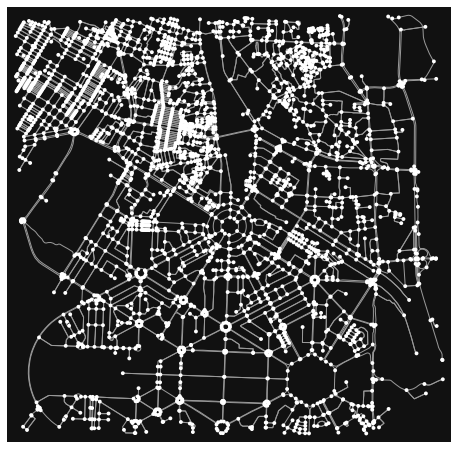

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
ox.plot_graph(Gp)

In [5]:
#1. Fast nearest node/edge search with OSMnx
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [6]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(Gp, X, Y, return_dist=True)

In [7]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(Gp, X0, Y0)
node

432874005

In [8]:
len(G)

3013

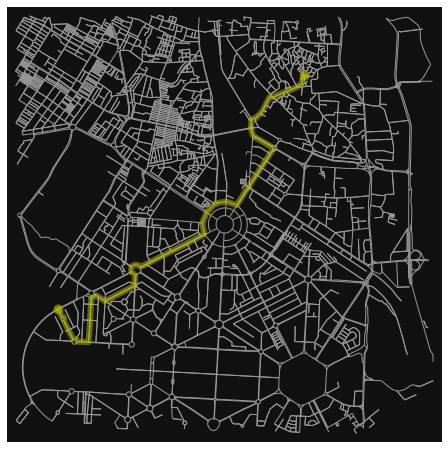

In [23]:
## 2.Basic routing by distance

# find the shortest path (by distance) between following nodes and plot.
orig = list(G)[27]
dest = list(G)[2650]
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

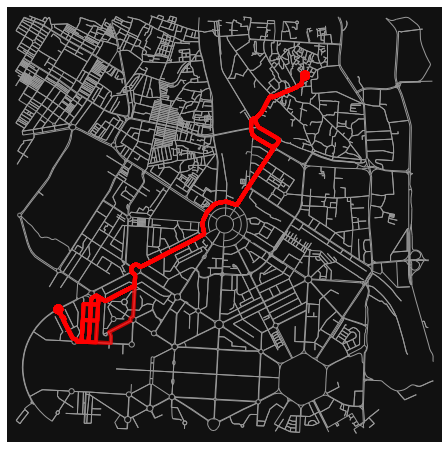

In [24]:
# get k shortest paths, weighted by some attribute:
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="r", route_linewidth=2, node_size=0)

In [11]:
routes

<generator object k_shortest_paths at 0x00000152A42D0AC0>

In [11]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [12]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'unclassified']",117.2,40.8,10.3
"['residential', 'living_street']",71.9,40.0,6.5
"['residential', 'tertiary']",200.1,40.0,18.0
"['residential', 'unclassified']",317.0,40.0,28.5
"['tertiary', 'residential']",200.1,40.8,17.7
"['tertiary', 'secondary']",108.2,40.8,9.5
"['tertiary', 'unclassified']",64.8,40.8,5.7
living_street,66.8,40.8,5.9
primary,192.9,70.0,9.9


In [13]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
Ga = ox.add_edge_speeds(G, hwy_speeds)
Ga = ox.add_edge_travel_times(Ga)

In [14]:
# see mean speed/time values by road type
edgesa = ox.graph_to_gdfs(Ga, nodes=False)
edgesa["highway"] = edgesa["highway"].astype(str)
edgesa.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'unclassified']",117.2,49.0,8.6
"['residential', 'living_street']",71.9,35.0,7.4
"['residential', 'tertiary']",200.1,35.0,20.6
"['residential', 'unclassified']",317.0,35.0,32.6
"['tertiary', 'residential']",200.1,60.0,12.0
"['tertiary', 'secondary']",108.2,60.0,6.5
"['tertiary', 'unclassified']",64.8,60.0,3.9
living_street,66.8,49.0,4.9
primary,192.9,70.0,9.9


In [12]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[27]
dest = list(G)[2700]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

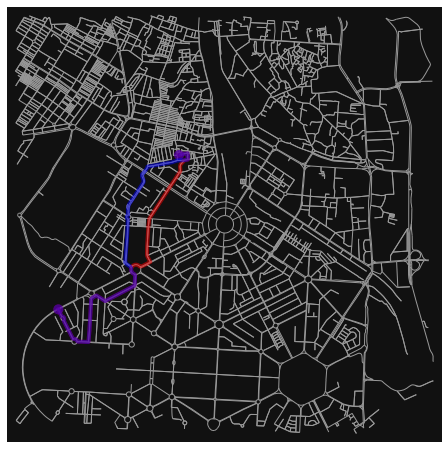

In [13]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["red", "blue"], route_linewidth=6, node_size=0)

In [14]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 4551 meters and takes 336 seconds.
Route 2 is 4750 meters and takes 333 seconds.


In [15]:
## solving multiple shortest paths at once 

# calculate 100,000 shortest-path routes using random origin-destination pairs
n = 10000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [16]:
%%time
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=None)

Wall time: 2min


In [17]:
%%time
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

Wall time: 2min 7s


In [18]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects ###### route_valid == rv #####
rv = [r for r in routes if r is not None]
print(len(rv))

10000
9711


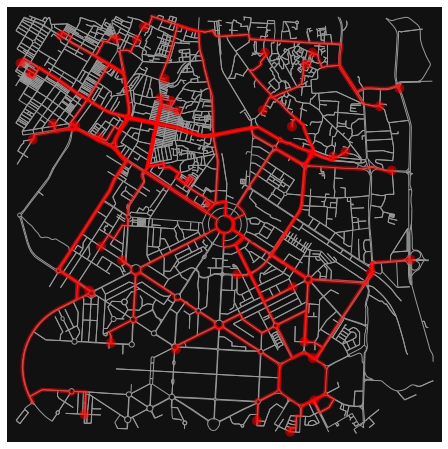

In [22]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[rv[50],rv[9700],rv[5] ,rv[8],rv[85],rv[678],rv[675],rv[752],rv[8724],rv[527],rv[2545]
              ,rv[475],rv[52],rv[53],rv[879],rv[8765],rv[54],rv[24],rv[5568],rv[59],rv[0]],
    route_linewidth=6, node_size=0)

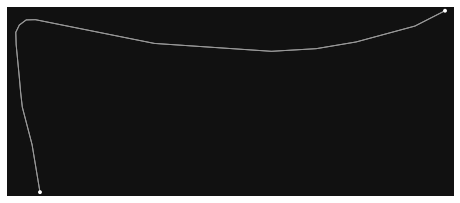

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [19]:
# filtering data with custon filter
G1 = ox.graph_from_place('mumbai,india',network_type = "drive",custom_filter='["waterway"~"canal"]')
ox.plot_graph(G1)

In [20]:
## Plot street neworks and routes as interactive leaflet web maps

import networkx as nx
import osmnx as ox
from IPython.display import IFrame

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [21]:
## Plot a city's street network as an interactive web map

# plot the street network with folium
m1 = ox.plot_graph_folium(G, popup_attribute="length", weight=2, color="red")

In [22]:
# save as html file then display map as an iframe
filepath = f"{fp}/small_delhi.html"
m1.save(filepath)
IFrame(filepath, width=600, height=500)

In [23]:
## PLOT A SINGLE ROUTE ON WEB MAP

# use networkx to calculate the shortest path between two nodes
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node)

In [24]:
# plot the route with folium
# like above, you can pass keyword args along to folium PolyLine to style the lines
m2 = ox.plot_route_folium(G, route, weight=10)

In [25]:
# save as html file then display map as an iframe
filepath = f"{fp}/route.html"
m2.save(filepath)
IFrame(filepath, width=600, height=500)

In [26]:
## PLOT A ROUTE ON TOP OF COMPLETE MAP

# plot the route with folium on top of the previously created graph_map
m3 = ox.plot_route_folium(G, route, route_map=m1, popup_attribute="length", weight=7)

In [27]:
# save as html file then display map as an iframe
filepath = f"{fp}/route_graph.html"
m3.save(filepath)
IFrame(filepath, width=600, height=500)

In [1]:
###############    ISOCHRONES     ###############

In [2]:
## ISOCHRONES WITH OSMNX

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon


In [3]:
# configure the place, network type, trip times, and travel speed

network_type = "walk"
trip_times = [5, 10, 15, 20, 40]  # in minutes
travel_speed = 5  # walking speed in km/hour

In [4]:
G = ox.graph_from_point((28.632748, 77.219670),dist = 3000,network_type = network_type)

In [5]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

In [6]:
print(x,y)

array('d', [77.2201503334689]) array('d', [28.636610007197913])


In [7]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [8]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

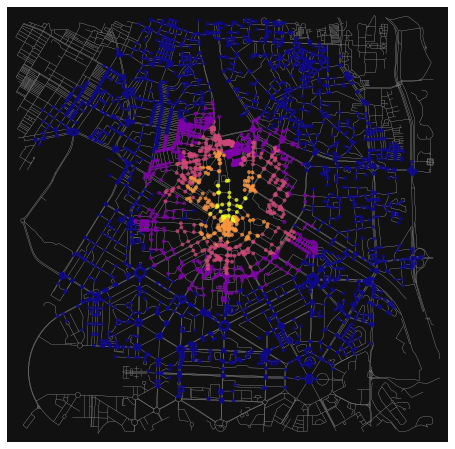

In [9]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G,node_color=nc,node_size=ns,node_alpha=0.8,edge_linewidth=0.2,edge_color="#999999",)

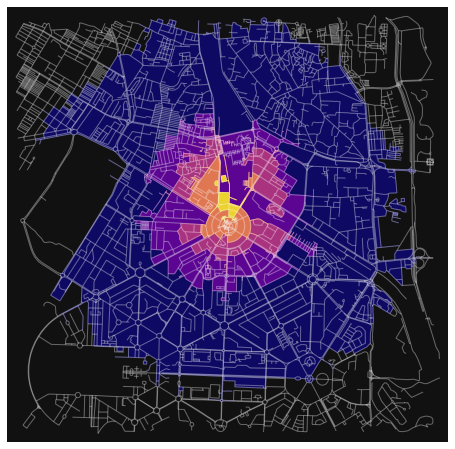

In [10]:
##  plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


isochrone_polys = make_iso_polys(G, edge_buff=5, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color="w", edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

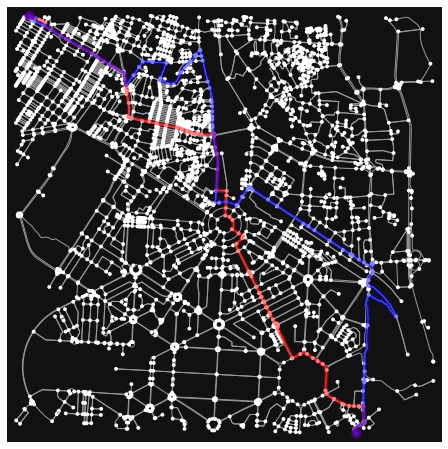

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [14]:
o = 9181732811
d = 1275190978
route_1 = ox.shortest_path(G, o, d, weight = 'length')
route_2 = ox.shortest_path(G, o, d, weight = 'travel_time')
ox.plot_graph_routes(G,[route_1,route_2], route_colors = ['red', 'blue'])